In [2]:
import pandas as pd
import datetime
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes
from tabulate import tabulate
import datetime as dt

In [3]:
us_confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
us_death_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
timestr = time.strftime("%Y%m%d-%H%M%S")

In [4]:
def get_n_melt_data(data_url, case_type, keys):
    df = pd.read_csv(data_url)
    reshape_df = df.melt(id_vars=keys)
    reshape_df.rename(columns={"variable": "Date", "value": case_type}, inplace=True)
    return reshape_df

def merge_data(confirmed, death):
    new_df = confirmed.join(death["Deaths"])
    new_df = new_df.join(death["Population"])
    return new_df

def fetch_data():
    confirm_df = get_n_melt_data(us_confirmed_cases_url, "Confirmed", ["UID","iso2","iso3","code3","FIPS","Admin2","Province_State","Country_Region","Lat","Long_","Combined_Key"])
    deaths_df = get_n_melt_data(us_death_cases_url, "Deaths", ["UID","iso2","iso3","code3","FIPS","Admin2","Province_State","Country_Region","Lat","Long_","Combined_Key","Population"])
    
    print("Getting and Reshaping Data")
    df = merge_data(confirm_df, deaths_df)
    print("Preview")
    #filename= "covid19_dataset_{}.csv".format(timestr)
    filename= "covid19_dataset_us.csv"
    print("Saving Data as {}".format(filename))
    df.to_csv(filename)
    print("Done")

fetch_data()

Getting and Reshaping Data
Preview
Saving Data as covid19_dataset_us.csv
Done


In [5]:
filename= "covid19_dataset_us.csv"
df = pd.read_csv(filename)
df = df[['Province_State', 'Country_Region', 'Lat', 'Long_', 'Date', 'Confirmed', 'Deaths',"Population"]]
df.head()


,Province_State,Country_Region,Lat,Long_,Date,Confirmed,Deaths,Population
0,American Samoa,US,-14.2710,-170.1320,1/22/20,0,0,55641
1,Guam,US,13.4443,144.7937,1/22/20,0,0,164229
2,Northern Mariana Islands,US,15.0979,145.6739,1/22/20,0,0,55144
3,Puerto Rico,US,18.2208,-66.5901,1/22/20,0,0,2933408
4,Virgin Islands,US,18.3358,-64.8963,1/22/20,0,0,107268


Max number of cases per country
Province_State              Confirmed    Deaths
------------------------  -----------  --------
New York                        72181      3485
Illinois                         8728       209
Michigan                         8270       346
New Jersey                       6862       247
California                       6377       147
Louisiana                        4565       171
Florida                          4481        49
Pennsylvania                     3728        45
Connecticut                      3719       101
Washington                       3331       222
Massachusetts                    2950        47
Indiana                          1956        37
Texas                            1809        22
Nevada                           1608        41
Arizona                          1433        31
Wisconsin                        1256        40
District of Columbia             1097        24
Missouri                         1033        13
Georgia 

C:\Users\chali\.conda\envs\my_env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


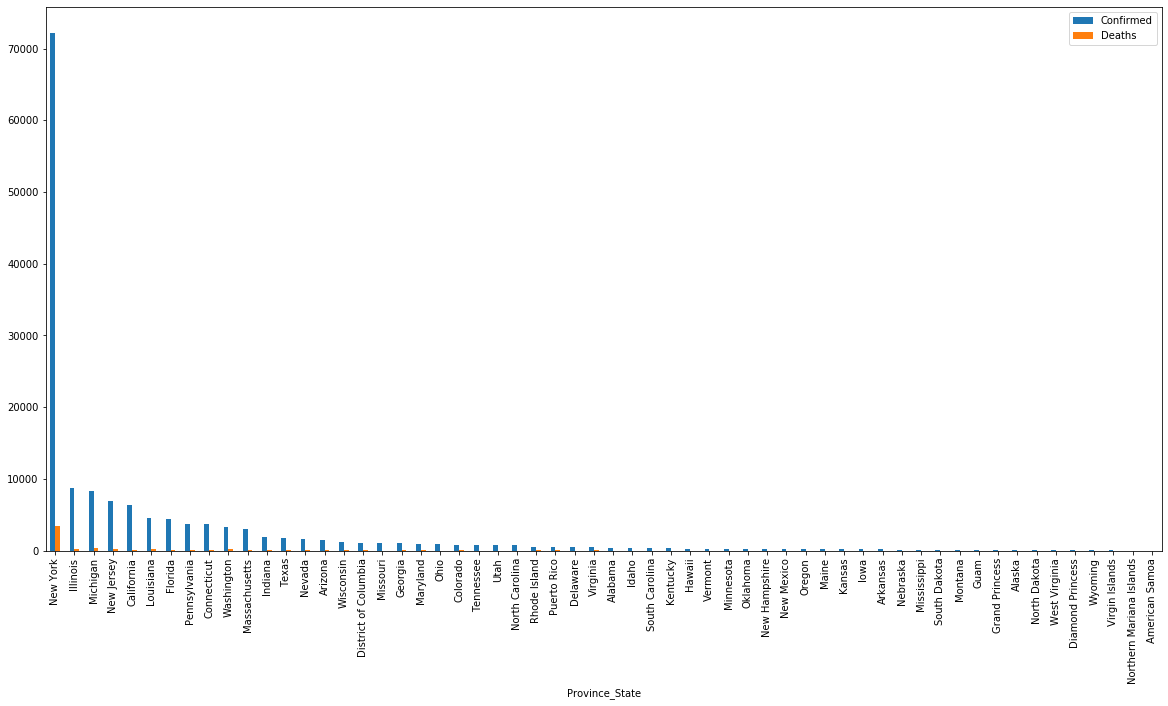

In [6]:
max_cases_per_state = df.groupby(['Province_State'])['Confirmed', 'Deaths'].max()
table_max_cases = max_cases_per_state.sort_values(by=['Confirmed'], ascending=False)
print("Max number of cases per country")
print(tabulate(table_max_cases,headers='keys'))
table_max_cases.plot(kind='bar', figsize=(20,10))

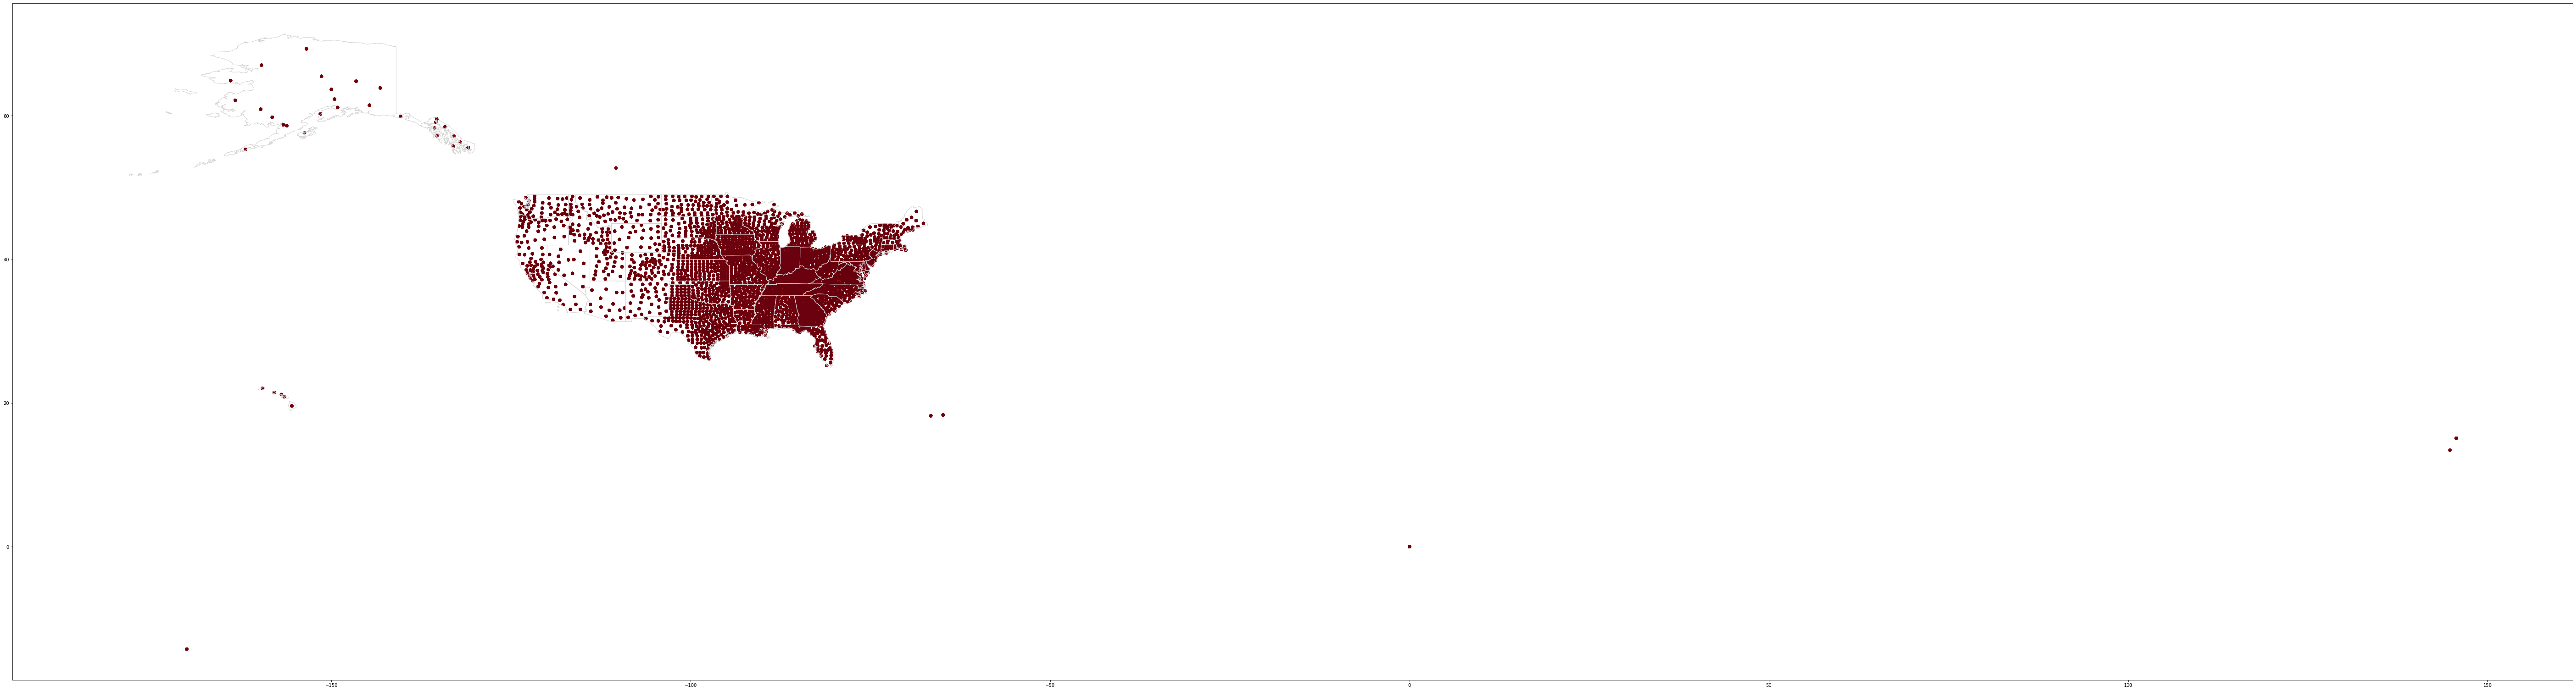

In [8]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Long_'], df['Lat']))
north_america = gpd.read_file("./states/states.shp")
fig,ax = plt.subplots(figsize=(100,50))
gdf.plot(cmap="Reds", ax=ax)
north_america.geometry.boundary.plot(color='lightgrey', edgecolor="white", linewidth=1, ax=ax, figsize=(100, 50))

In [9]:
df2 = df
df.to_csv("covid19_dataset_us_clean.csv")
df['cases_dates'] =  pd.to_datetime(df2['Date'])

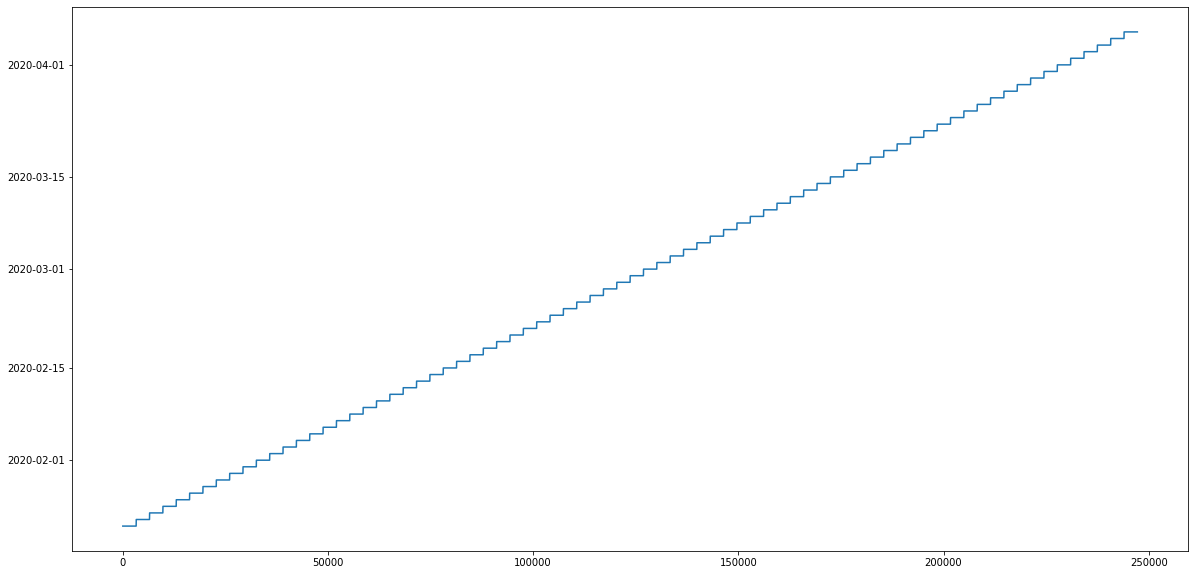

In [10]:
df['cases_dates'].plot(figsize=(20,10))

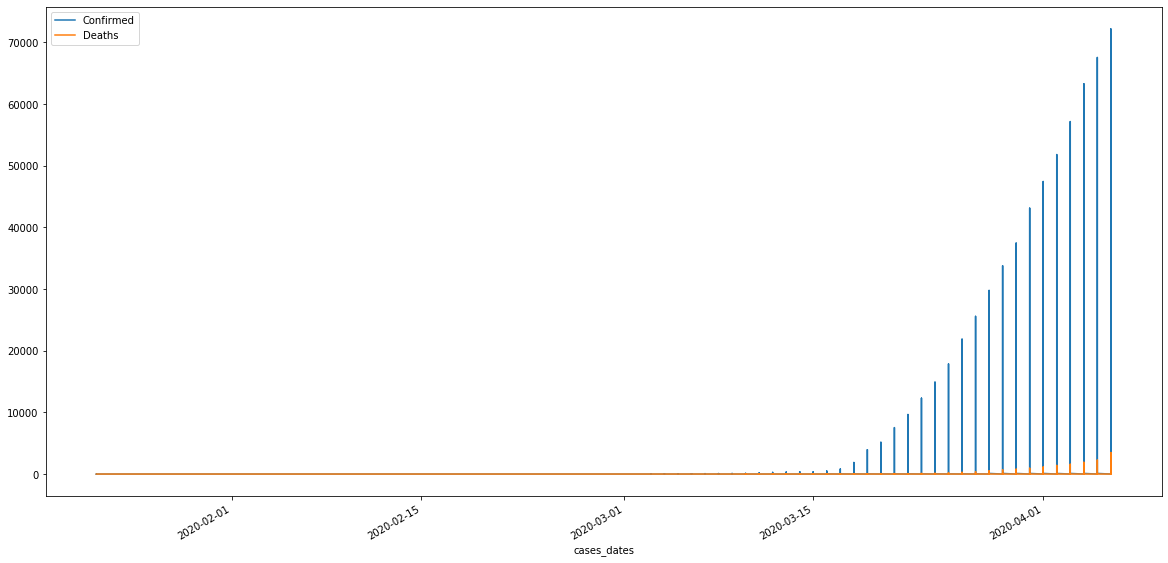

In [11]:
df2.set_index('cases_dates')[['Confirmed','Deaths']].plot(figsize=(20,10))

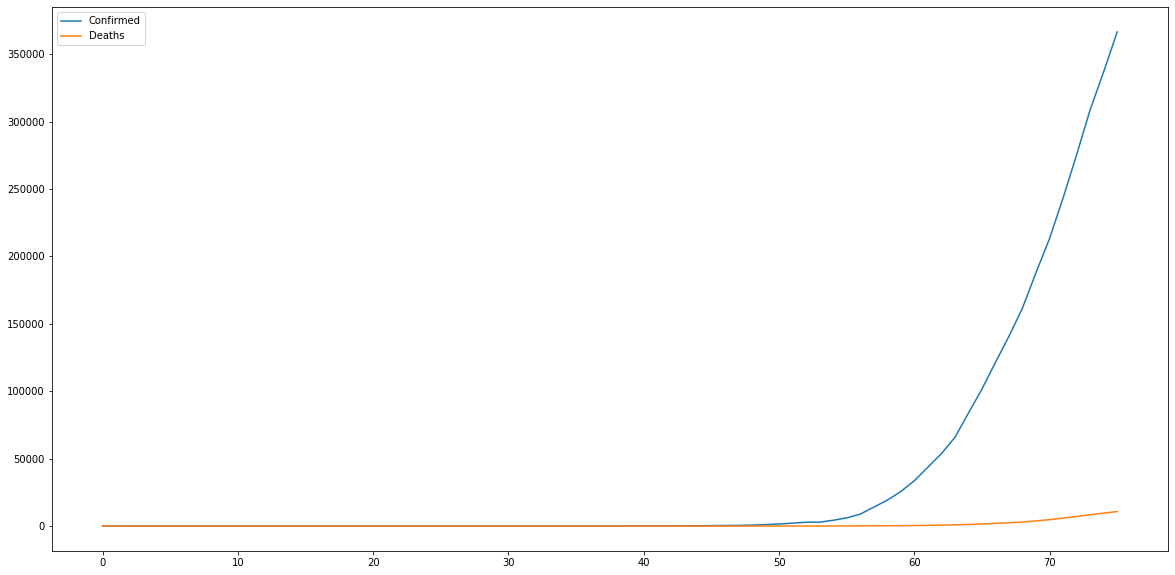

In [12]:
df_by_date = df2.set_index('cases_dates').groupby(['cases_dates']).sum().reset_index(drop=None)
df_by_date[['Confirmed', 'Deaths']].plot(kind='line', figsize=(20,10))

    cases_dates              Lat     Long_    Confirmed    Deaths    Population
--  -------------------  -------  --------  -----------  --------  ------------
75  2020-04-06 00:00:00  1989.92  -5876.75        14867       512       4648794
74  2020-04-05 00:00:00  1989.92  -5876.75        13010       477       4648794
73  2020-04-04 00:00:00  1989.92  -5876.75        12496       409       4648794
72  2020-04-03 00:00:00  1989.92  -5876.75        10297       370       4648794
71  2020-04-02 00:00:00  1989.92  -5876.75         9159       310       4648794
70  2020-04-01 00:00:00  1989.92  -5876.75         6424       273       4648794
69  2020-03-31 00:00:00  1989.92  -5876.75         5237       239       4648794
68  2020-03-30 00:00:00  1989.92  -5876.75         4025       185       4648794
67  2020-03-29 00:00:00  1989.92  -5876.75         3540       151       4648794
66  2020-03-28 00:00:00  1989.92  -5876.75         3315       137       4648794
65  2020-03-27 00:00:00  1989.92  -5876.

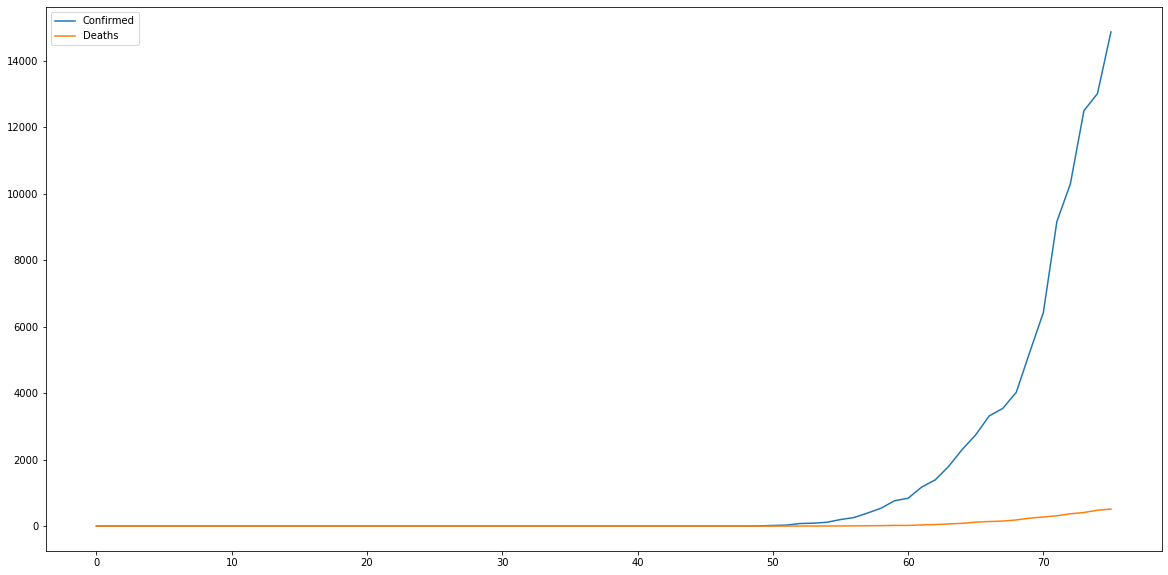

In [26]:
louisiana_cases = df[df['Province_State'] == 'Louisiana'].set_index('cases_dates').groupby(['cases_dates']).sum().reset_index(drop=None)
louisiana_cases_asc = louisiana_cases.sort_values(by=['Confirmed'], ascending=False)
print(tabulate(louisiana_cases_asc, headers="keys"))

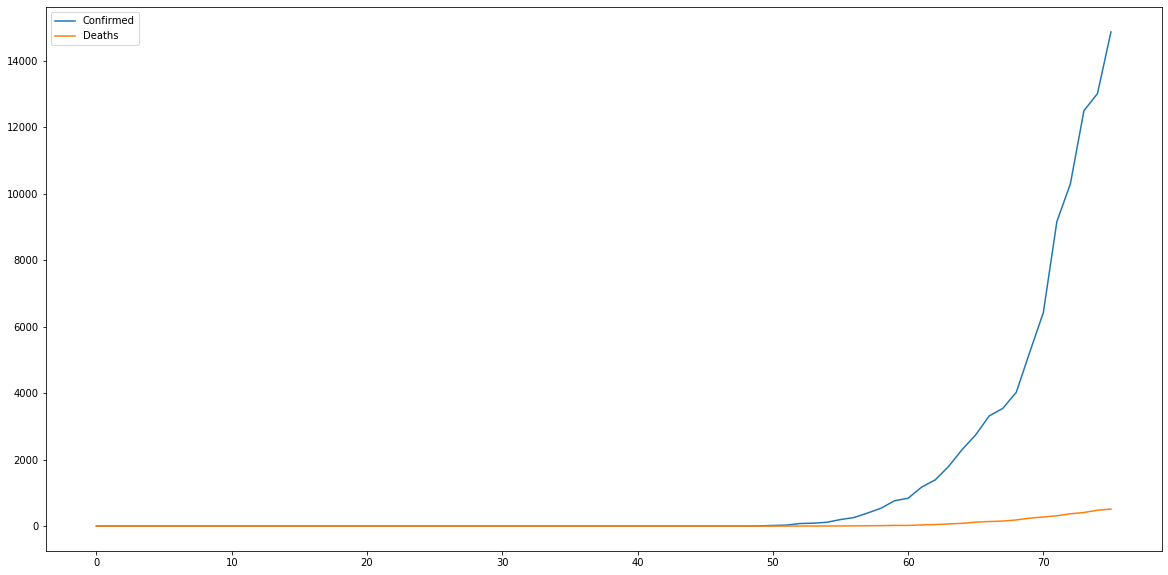

In [27]:
louisiana_cases[['Confirmed', 'Deaths']].plot(kind='line', figsize=(20,10))